In [84]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from pydub import AudioSegment
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import (confusion_matrix, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve, classification_report,
                             accuracy_score, auc)
import seaborn as sns
from tqdm import tqdm
from scipy.stats import ttest_rel
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [85]:
AUDIO_PATH = "/speech_understanding/data/UrbanSound8K/audio"
METADATA_PATH = "/speech_understanding/data/UrbanSound8K/metadata/UrbanSound8K.csv"

if not os.path.exists(METADATA_PATH):
    raise FileNotFoundError("UrbanSound8K metadata file not found at the given path!")
df = pd.read_csv(METADATA_PATH)

if not os.path.exists(AUDIO_PATH):
    raise FileNotFoundError("UrbanSound8K dataset not found at the given path!")



Number of classes: 10


/tmp/ipykernel_4187836/1515149302.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['classID'], palette='viridis')


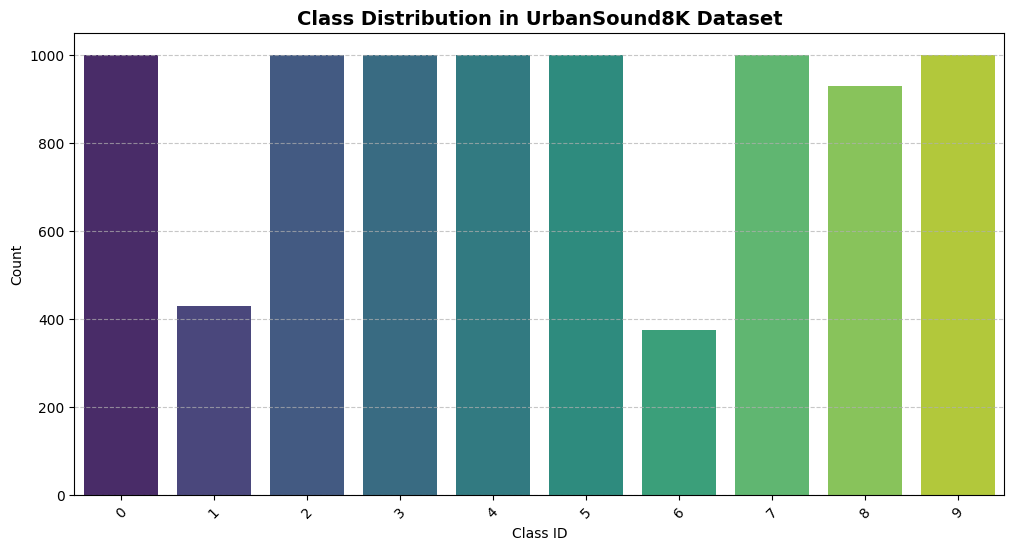

In [86]:
NUM_CLASSES = df["classID"].nunique()
print(f"Number of classes: {NUM_CLASSES}")

label_encoder = LabelEncoder()
df['encoded'] = label_encoder.fit_transform(df['classID'].values)

FRAME_LEN = 1024
HOP_LEN = 512
MAX_LEN = 128  


plt.figure(figsize=(12, 6))
sns.countplot(x=df['classID'], palette='viridis')
plt.title("Class Distribution in UrbanSound8K Dataset", fontsize=14, fontweight='bold')
plt.xlabel("Class ID")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [87]:
#Hann window
hann_window = 0.5 * (1 - np.cos(2 * np.pi * np.arange(FRAME_LEN) / (FRAME_LEN - 1)))

#Hamming window
a0 = 0.54
a1 = 1 - a0
hamming_window = a0 - a1 * np.cos(2 * np.pi * np.arange(FRAME_LEN) / (FRAME_LEN - 1))

#Rectangular window
rectangular_window = np.ones(FRAME_LEN)

window_functions = {
    'Hann': hann_window,
    'Hamming': hamming_window,
    'Rectangular': rectangular_window
}


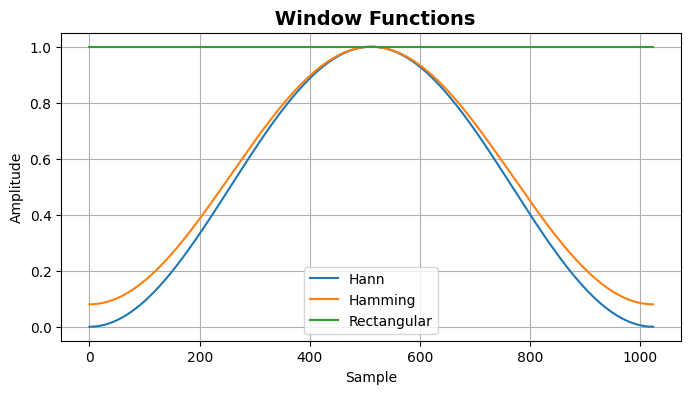

In [88]:
plt.figure(figsize=(8, 4))
for name, window in window_functions.items():
    plt.plot(window, label=name)
plt.title(" Window Functions", fontsize=14, fontweight='bold')
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

In [89]:
X = df[['fold', 'slice_file_name']].values
y = df['classID'].values
train_X, test_X, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Number of training files: {len(train_X)}")
print(f"Number of testing files: {len(test_X)}")

Number of training files: 6985
Number of testing files: 1747


In [90]:
def preprocess_audio(file_path):
    audio = AudioSegment.from_file(file_path, format="mp3")
    target_sr = 44100
    audio = audio.set_channels(1).set_frame_rate(target_sr)
    temp_wav = "temp.wav"
    audio.export(temp_wav, format="wav")
    y, sr = librosa.load(temp_wav, sr=target_sr)
    return y, sr



In [91]:
def calculate_rmse(original_signal, windowed_signal):
    return np.sqrt(np.mean((original_signal - windowed_signal) ** 2))

In [92]:
def calculate_cumulative_error(original_signal, windowed_signal):
    return np.sum(np.abs(original_signal - windowed_signal))


In [93]:
def create_spectrogram(audio, window, frame_length=FRAME_LEN, hop_length=HOP_LEN):
    
    stft = librosa.stft(audio, n_fft=frame_length, hop_length=hop_length, window=window)
    spectrogram = np.abs(stft)
    
    windowed_signal = librosa.istft(stft, hop_length=hop_length, window=window)
    
    min_len = min(len(audio), len(windowed_signal))
    original_signal = audio[:min_len]
    windowed_signal = windowed_signal[:min_len]
    
    return spectrogram, original_signal, windowed_signal

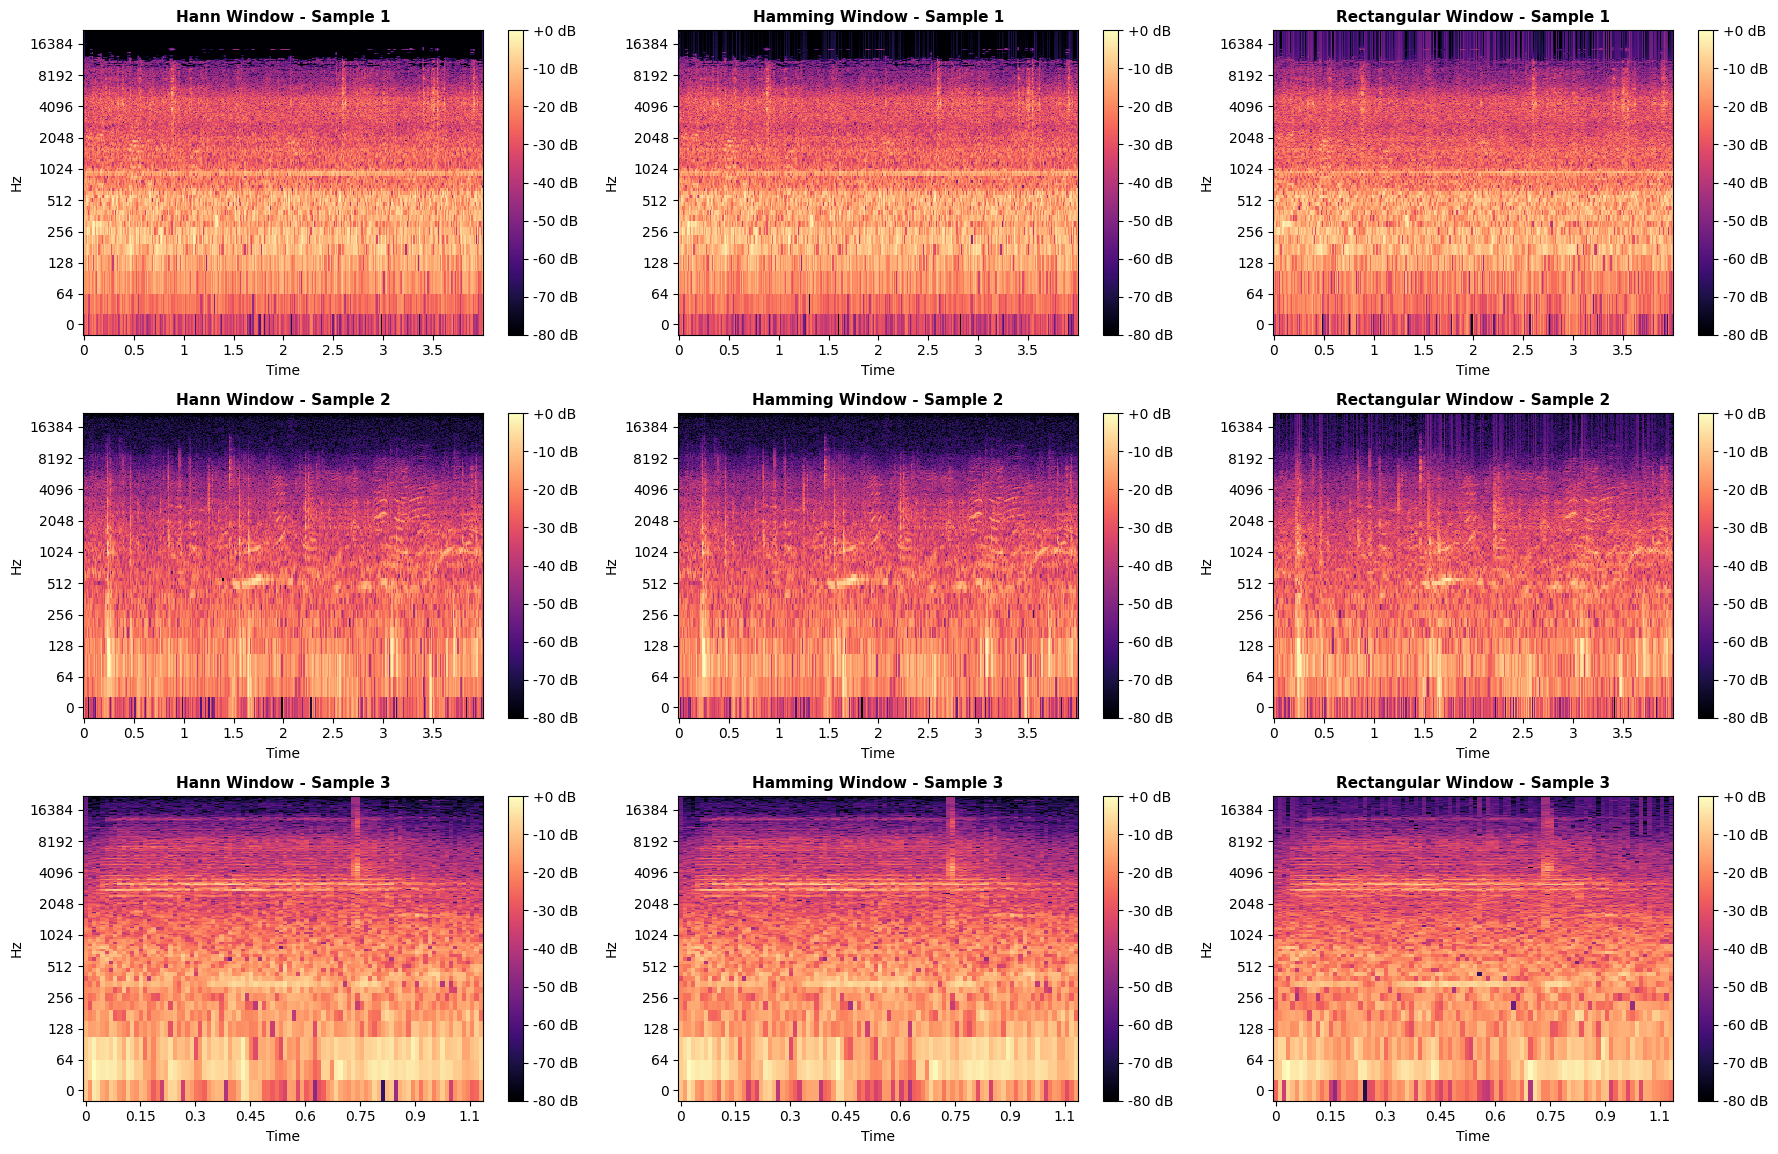

In [110]:
num_samples = 3
random_samples = random.sample(list(train_X), num_samples)  

plt.figure(figsize=(18, 12))  

for sample_idx, (sample_fold, sample_file) in enumerate(random_samples):
    sample_path = os.path.join(AUDIO_PATH, f"fold{sample_fold}", sample_file)
    if os.path.exists(sample_path):
        audio, sr = librosa.load(sample_path, sr=None)
        for i, (name, window) in enumerate(window_functions.items(), 1):
            plt.subplot(num_samples, 3, sample_idx * 3 + i) 
            spectrogram, _, _ = create_spectrogram(audio, window)
            librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max),
                                     sr=sr, hop_length=HOP_LEN, y_axis='log', x_axis='time')
            plt.title(f'{name} Window - Sample {sample_idx + 1}', fontsize=11, fontweight='bold')
            plt.colorbar(format='%+2.0f dB')
    else:
        print(f"Sample file {sample_file} not found in fold{sample_fold}.")

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [95]:
snr_results = {}
rmse_results = {}
cumulative_error_results = {}

for name, window in window_functions.items():
    print(f"\nComputing metrics for {name} window...")
    snr_list = []
    rmse_list = []
    cumulative_error_list = []
    
    for (fold, file) in tqdm(train_X, total=len(train_X), desc=f'Computing metrics for {name}'):
        file_path = os.path.join(AUDIO_PATH, f"fold{fold}", file)
        if not os.path.exists(file_path):
            continue
        
        audio, sr = librosa.load(file_path, sr=None)
        spectrogram, original_signal, windowed_signal = create_spectrogram(audio, window)
        
        rmse = calculate_rmse(original_signal, windowed_signal)
        cumulative_error = calculate_cumulative_error(original_signal, windowed_signal)
        
        rmse_list.append(rmse)
        cumulative_error_list.append(cumulative_error)
    
    rmse_results[name] = np.mean(rmse_list)
    cumulative_error_results[name] = np.mean(cumulative_error_list)

print("\n=== Signal Quality Metrics ===")
for name in window_functions.keys():
    print(f"\n--- {name} Window ---")
    print(f"RMSE: {rmse_results[name]:.4f}")
    print(f"Cumulative Error: {cumulative_error_results[name]:.4f}")


Computing metrics for Hann window...


Computing metrics for Hann: 100%|██████████| 6985/6985 [00:53<00:00, 129.54it/s]



Computing metrics for Hamming window...


Computing metrics for Hamming: 100%|██████████| 6985/6985 [00:53<00:00, 129.97it/s]



Computing metrics for Rectangular window...


Computing metrics for Rectangular: 100%|██████████| 6985/6985 [00:54<00:00, 129.24it/s]


=== Signal Quality Metrics ===

--- Hann Window ---
RMSE: 0.0000
Cumulative Error: 0.0003

--- Hamming Window ---
RMSE: 0.0000
Cumulative Error: 0.0003

--- Rectangular Window ---
RMSE: 0.0000
Cumulative Error: 0.0001


In [96]:
def process_training_files(train_X, y_train, window, max_length, audio_path):
    features = []
    processed_labels = []
   
    for (fold, file), label in tqdm(zip(train_X, y_train), total=len(train_X), desc='Processing Training'):
        file_path = os.path.join(audio_path, f"fold{fold}", file)
        if not os.path.exists(file_path):
            continue  
        
        audio, sr = librosa.load(file_path, sr=None)
        spectrogram, _, _ = create_spectrogram(audio, window)

        if spectrogram.shape[1] < max_length:
            pad_width = max_length - spectrogram.shape[1]
            spectrogram = np.pad(spectrogram, ((0, 0), (0, pad_width)), mode='constant')
        else:
            spectrogram = spectrogram[:, :max_length]

        spectrogram = librosa.amplitude_to_db(spectrogram, ref=np.max)

        features.append(spectrogram)
        processed_labels.append(label)

    print(f"Processed {len(features)} training files.")
    return np.array(features), np.array(processed_labels)




In [97]:
def process_testing_files(test_X, y_test, window, max_length, audio_path):
    features = []
    processed_labels = []
    
    for (fold, file), label in tqdm(zip(test_X, y_test), total=len(test_X), desc='Processing Testing'):
        file_path = os.path.join(audio_path, f"fold{fold}", file)
        if not os.path.exists(file_path):
            continue  

        audio, sr = librosa.load(file_path, sr=None)
        spectrogram, _, _ = create_spectrogram(audio, window)

        if spectrogram.shape[1] < max_length:
            pad_width = max_length - spectrogram.shape[1]
            spectrogram = np.pad(spectrogram, ((0, 0), (0, pad_width)), mode='constant')
        else:
            spectrogram = spectrogram[:, :max_length]

        spectrogram = librosa.amplitude_to_db(spectrogram, ref=np.max)

        features.append(spectrogram)
        processed_labels.append(label)

    print(f"Processed {len(features)} testing files.")
    return np.array(features), np.array(processed_labels)


In [98]:
features_dict, labels_dict = {}, {}
test_features_dict, test_labels_dict = {}, {}

for name, window in window_functions.items():
    print(f"\nProcessing files using {name} window...")

    features, labels = process_training_files(train_X, y_train, window, MAX_LEN, AUDIO_PATH)
    features_dict[name] = features
    labels_dict[name] = labels

    test_features, test_labels = process_testing_files(test_X, y_test, window, MAX_LEN, AUDIO_PATH)
    test_features_dict[name] = test_features
    test_labels_dict[name] = test_labels


Processing files using Hann window...


Processing Training:   0%|          | 25/6985 [00:00<00:58, 119.74it/s]

Processing Training: 100%|██████████| 6985/6985 [00:59<00:00, 117.54it/s]


Processed 6985 training files.


Processing Testing: 100%|██████████| 1747/1747 [00:14<00:00, 118.58it/s]


Processed 1747 testing files.

Processing files using Hamming window...


Processing Training: 100%|██████████| 6985/6985 [01:00<00:00, 116.09it/s]


Processed 6985 training files.


Processing Testing: 100%|██████████| 1747/1747 [00:14<00:00, 118.70it/s]


Processed 1747 testing files.

Processing files using Rectangular window...


Processing Training: 100%|██████████| 6985/6985 [00:59<00:00, 117.21it/s]


Processed 6985 training files.


Processing Testing: 100%|██████████| 1747/1747 [00:14<00:00, 119.93it/s]

Processed 1747 testing files.


In [99]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32).unsqueeze(1)  
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return self.features.shape[0]
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [100]:
class CustomCNNClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNNClassifier, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2))
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(64 * 64 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x


In [101]:
results = {}

num_epochs = 20
batch_size = 32
learning_rate = 0.001

def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        loop = tqdm(train_loader, leave=False, desc=f'Training Epoch {epoch+1}/{num_epochs}')
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            loop.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


In [102]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        loop = tqdm(test_loader, leave=False, desc=f'Evaluating Model')
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)

            all_probs.extend(probs.cpu().numpy())
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds, all_probs


In [ ]:
for name in window_functions.keys():
    print(f'\n=== Training CNN with {name} Window ===')

    X_train, y_tr = features_dict[name], labels_dict[name]
    X_test, y_te = test_features_dict[name], test_labels_dict[name]

    if len(X_train) == 0 or len(X_test) == 0:
        print(f"No data available for {name} window. Skipping...")
        continue

    train_dataset = CustomDataset(X_train, y_tr)
    test_dataset = CustomDataset(X_test, y_te)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = CustomCNNClassifier(num_classes=NUM_CLASSES).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_model(model, train_loader, criterion, optimizer, num_epochs)

    all_labels, all_preds, all_probs = evaluate_model(model, test_loader)

    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=1)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=1)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=1)
    roc_auc = roc_auc_score(all_labels, np.eye(NUM_CLASSES)[np.array(all_preds)], 
                            average='macro', multi_class='ovr')

    results[name] = {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'classification_report': classification_report(all_labels, all_preds, 
                                                       target_names=label_encoder.classes_.astype(str))
    }
    print(f'\nResults for {name} Window:')
    print(f'Accuracy: {acc:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC-AUC: {roc_auc:.4f}')



=== Training CNN with Hann Window ===


Epoch [1/20], Loss: 3.4217


Epoch [2/20], Loss: 1.8900


Epoch [3/20], Loss: 1.7132


Epoch [4/20], Loss: 1.5625


Epoch [5/20], Loss: 1.4263


Epoch [6/20], Loss: 1.3391


Epoch [7/20], Loss: 1.2495


Epoch [8/20], Loss: 1.1557


Epoch [9/20], Loss: 1.0942


Epoch [10/20], Loss: 1.0196


Epoch [11/20], Loss: 0.9589


Epoch [12/20], Loss: 0.9477


Epoch [13/20], Loss: 0.8549


Epoch [14/20], Loss: 0.8055


Epoch [15/20], Loss: 0.7663


Epoch [16/20], Loss: 0.7384


Epoch [17/20], Loss: 0.6987


Epoch [18/20], Loss: 0.6544


Epoch [19/20], Loss: 0.6495


Epoch [20/20], Loss: 0.5815



Results for Hann Window:
Accuracy: 0.8054
Precision: 0.8185
Recall: 0.8160
F1 Score: 0.8141
ROC-AUC: 0.8971

=== Training CNN with Hamming Window ===


Epoch [1/20], Loss: 3.1345


Epoch [2/20], Loss: 1.9384


Epoch [3/20], Loss: 1.8217


Epoch [4/20], Loss: 1.7328


Epoch [5/20], Loss: 1.6707


Epoch [6/20], Loss: 1.5748


Epoch [7/20], Loss: 1.5027


Epoch [8/20], Loss: 1.4537


Epoch [9/20], Loss: 1.3875


Epoch [10/20], Loss: 1.3065


Epoch [11/20], Loss: 1.2567


Epoch [12/20], Loss: 1.2125


Epoch [13/20], Loss: 1.1400


Epoch [14/20], Loss: 1.0758


Epoch [15/20], Loss: 1.0384


Epoch [16/20], Loss: 0.9973


Epoch [17/20], Loss: 0.9632


Epoch [18/20], Loss: 0.9379


Epoch [19/20], Loss: 0.8249


Epoch [20/20], Loss: 0.8170



Results for Hamming Window:
Accuracy: 0.7619
Precision: 0.7977
Recall: 0.7677
F1 Score: 0.7775
ROC-AUC: 0.8705

=== Training CNN with Rectangular Window ===


Epoch [1/20], Loss: 3.0718


Epoch [2/20], Loss: 1.8459


Epoch [3/20], Loss: 1.7526


Epoch [4/20], Loss: 1.6646


Epoch [5/20], Loss: 1.5991


Epoch [6/20], Loss: 1.4906


Epoch [7/20], Loss: 1.4031


Epoch [8/20], Loss: 1.3535


Epoch [9/20], Loss: 1.2882


Epoch [10/20], Loss: 1.2358


Epoch [11/20], Loss: 1.1958


Epoch [12/20], Loss: 1.1142


Epoch [13/20], Loss: 1.0835


Epoch [14/20], Loss: 1.0432


Epoch [15/20], Loss: 0.9921


Epoch [16/20], Loss: 0.9785


Epoch [17/20], Loss: 0.9063


Epoch [18/20], Loss: 0.8829


Epoch [19/20], Loss: 0.8482


Epoch [20/20], Loss: 0.8339



Results for Rectangular Window:
Accuracy: 0.7333
Precision: 0.7531
Recall: 0.7473
F1 Score: 0.7428
ROC-AUC: 0.8587


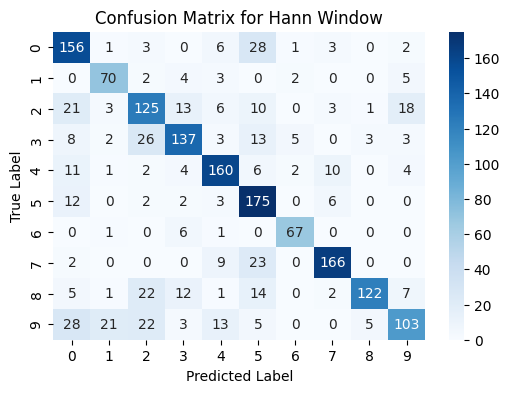

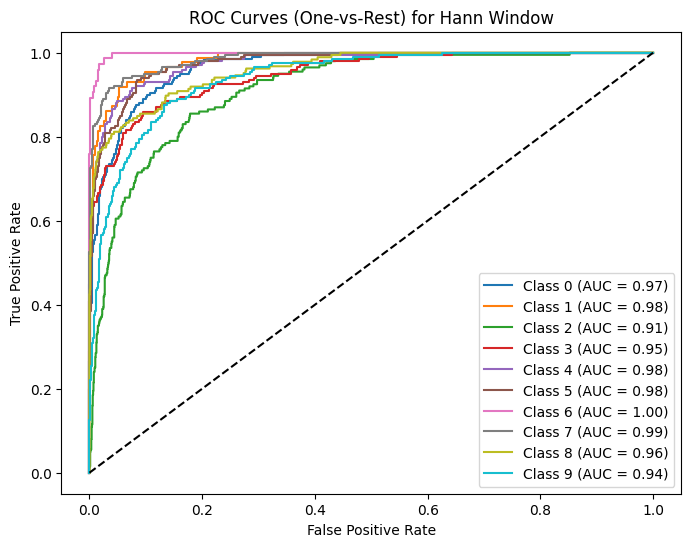

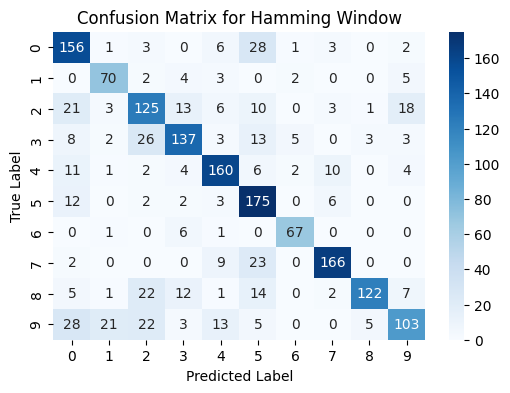

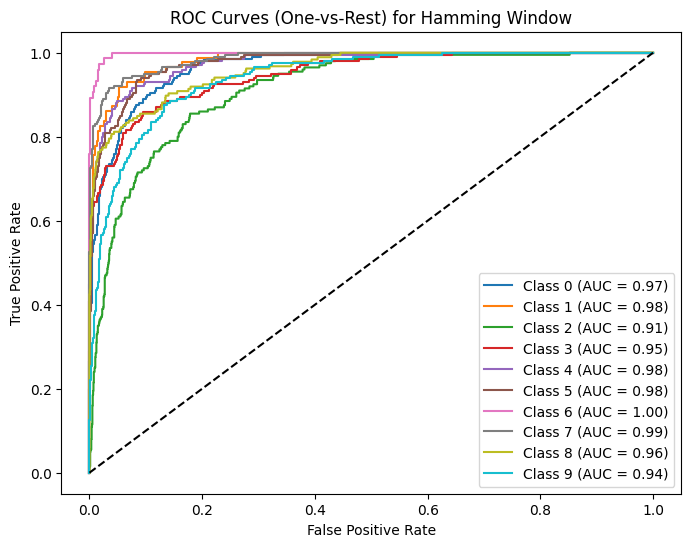

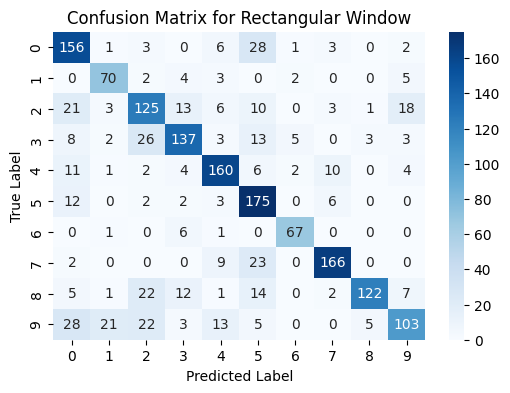

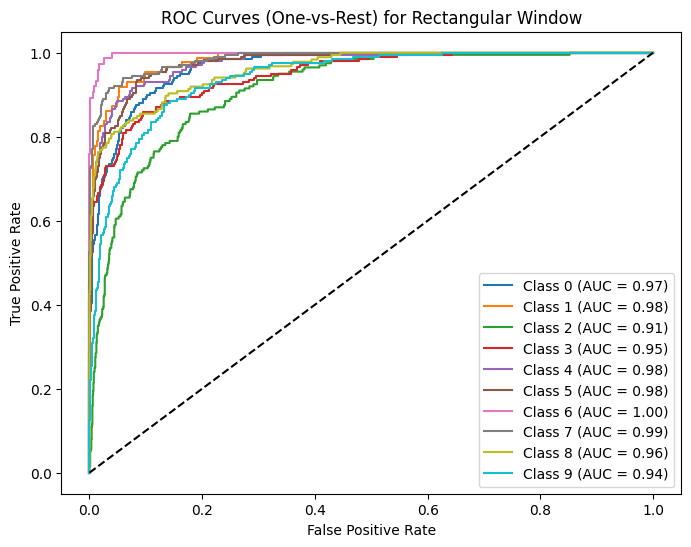

In [104]:
def plot_confusion_matrix(all_labels, all_preds, name):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 4))  
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.title(f"Confusion Matrix for {name} Window")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

def plot_roc_curves(all_labels, all_probs, name):
    y_true_bin = label_binarize(all_labels, classes=range(NUM_CLASSES))
    all_probs = np.array(all_probs)
    fpr, tpr, roc_auc_class = {}, {}, {}

    for i in range(NUM_CLASSES):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
        roc_auc_class[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    for i in range(NUM_CLASSES):
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc_class[i]:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves (One-vs-Rest) for {name} Window")
    plt.legend(loc='best')
    plt.show()

for name in results.keys():
    plot_confusion_matrix(all_labels, all_preds, name)
    plot_roc_curves(all_labels, all_probs, name)


In [105]:
print('\n=== Comparison of Windowing Techniques ===')
for name, res in results.items():
    print(f'\n--- {name} Window ---')
    print(f'Accuracy: {res["accuracy"]:.4f}')
    print(f'Precision: {res["precision"]:.4f}')
    print(f'Recall: {res["recall"]:.4f}')
    print(f'F1 Score: {res["f1"]:.4f}')
    if res["roc_auc"] is not None:
        print(f'ROC-AUC: {res["roc_auc"]:.4f}')



=== Comparison of Windowing Techniques ===

--- Hann Window ---
Accuracy: 0.8054
Precision: 0.8185
Recall: 0.8160
F1 Score: 0.8141
ROC-AUC: 0.8971

--- Hamming Window ---
Accuracy: 0.7619
Precision: 0.7977
Recall: 0.7677
F1 Score: 0.7775
ROC-AUC: 0.8705

--- Rectangular Window ---
Accuracy: 0.7333
Precision: 0.7531
Recall: 0.7473
F1 Score: 0.7428
ROC-AUC: 0.8587
